Aline Freire de Rezende<br>116110571

[v] tá dentro do triângulo?<br>
[  ] tá dentro do poligono?<br>
[  ] triangularização de círculo<br>
[v] bounding box<br>
[  ] transformação<br>

# Python imports

In [1]:
import numpy as np
import scipy as sp
from google.colab.patches import cv2_imshow
from google.colab import files
from matplotlib import patheffects
import matplotlib.pyplot as plt
import json

## JSON upload

In [2]:
from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  f = open(fn, )
  graphic_data = json.load(f)
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

Saving polygon.json to polygon.json
User uploaded file "polygon.json" with length 240 bytes


# Code (inside test and Screen class)

In [3]:
def inside(x, y, primitive):
  """
  Check if point (x,y) is inside the primitive
  
  Args:
    x (float): horizontal point position
    y (float): vertical point position
  Returns:
    True if (x,y) is inside the primitive, False case contrary
  """
  
  # You should implement your inside test here for all shapes   
  # for now, it only returns a false test

  if "xform" in primitive:
    if (primitive["shape"] == "circle"):
      for triangle in primitive["transTriangles"]:
        if (insideTriangle(x, y, triangle) == True):
          return True
      return False  
      
    if (primitive["shape"] == "triangle"):
      if (insideTriangle(x, y, primitive["transVertices"]) == True):
        return True
      return False

    # else: #polígono


  if (primitive["shape"] == "triangle"):
    vertices = primitive["vertices"].copy()
    if (insideTriangle(x, y, vertices) == True):
      return True
    return False

  if (primitive["shape"] == "circle"):
    for triangle in primitive["triangulation"]:
      if (insideTriangle(x, y, triangle) == True):
        return True

  return False

In [4]:
#def insidePolygon(polygon):

In [5]:
def circleTransformation(primitive):
  transTri = []

  for triangle in primitive["triangulation"]:
    dic = {}
    dic["xform"] = primitive["xform"]
    dic["vertices"] = triangle
    transformation(dic)
    transTri.append(dic["transVertices"])

  primitive["transTriangles"] = transTri

  return  

In [6]:
def transformation(primitive):
  transMatrix = primitive["xform"]
  vertices = primitive["vertices"].copy()
  trans = []

  for vertice in vertices:
    x = vertice[0]
    y = vertice[1]
    xNew = transMatrix[0][0] * x + transMatrix[0][1] * y + transMatrix[0][2] * 1
    yNew = transMatrix[1][0] * x + transMatrix[1][1] * y + transMatrix[1][2] * 1
    trans.append([xNew, yNew])

  primitive["transVertices"] = trans

  return

In [7]:
def boundingBox(primitive): # consiste em pegar os maiores e menores x's e y's
  
  if (primitive["shape"] == "circle"):
    if "xform" in primitive:
      for triangle in primitive["triangulation"]:
        points = triangle

        xMin = min(vertice[0] for vertice in points)
        xMax = max(vertice[0] for vertice in points)
        yMin = min(vertice[1] for vertice in points)
        yMax = max(vertice[1] for vertice in points)
      
    else:
      center = primitive["center"]
      radius = primitive["radius"]

      xMin = center[0] - radius
      xMax = center[0] + radius
      yMin = center[1] - radius
      yMax = center[1] + radius

  else:
    if "xform" in primitive:
      points = primitive["transVertices"].copy()
    else:
      points = primitive["vertices"].copy()

    xMin = min(vertice[0] for vertice in points)
    xMax = max(vertice[0] for vertice in points)
    yMin = min(vertice[1] for vertice in points)
    yMax = max(vertice[1] for vertice in points)

  xMin = int(xMin)
  xMax = int(xMax + 1)
  yMin = int(yMin)
  yMax = int(yMax + 1)

  return ([xMin, xMax], [yMin, yMax])

In [8]:
def circleTriangulation(circle): # centro, raio * cosseno, raio * seno
  triangles = []
  points = []
  slices = 60

  for i in range(slices):
    # somei ao centro pois o círculo não está necessariamente centrado na origem
    x = circle["center"][0] + (circle["radius"] * np.cos((2 * np.pi * i) / 60))
    y = circle["center"][1] + (circle["radius"] * np.sin((2 * np.pi * i) / 60)) 
    point = [x, y]
    points.append(point)

  for i in range(slices):
    A = circle["center"].copy()
    B = points[i].copy()
    C = points[(i+1)%slices].copy() 
    triangles.append([A, B, C])

  return triangles

In [9]:
def buildsVector(pointA, pointB): # AB = B - A
  vector = np.zeros(2, int)

  iA = pointA[0]
  jA = pointA[1]
  iB = pointB[0]
  jB = pointB[1]

  vector[0] = iB-iA
  vector[1] = jB-jA

  return vector

In [10]:
def findNormal(vector): # é basicamente uma rotação anti-horária
  normal = np.zeros(2, int)
  
  i = vector[0]
  j = vector[1]

  normal[0] = -j
  normal[1] = i

  return normal

In [11]:
def insideTriangle(x, y, triangle): # para rotação no sentido anti-horário

  #inicialização de variáveis
  AB = BC = CA = np.zeros(2, int)
  Ap = Bp = Cp = np.zeros(2, int)
  nAB = nBC = nCA = np.zeros(2, int)
  alfaAB = alfaBC = alfaCA = 0
  
  # Ajustando os vértices e o ponto
  A = triangle[0]
  B = triangle[1]
  C = triangle[2]
  p = np.array([x,y])

  # Construindo os vetores do triângulo
  AB = buildsVector(A, B)
  BC = buildsVector(B, C)
  CA = buildsVector(C, A)
    
  # Construindo os vetores de cada vértice ao ponto
  Ap = buildsVector(A, p)
  Bp = buildsVector(B, p)
  Cp = buildsVector(C, p)

  # Encontrando as normais (para dentro) aos vetores do triângulo
  nAB = findNormal(AB)
  nBC = findNormal(BC)
  nCA = findNormal(CA)

  # Produto interno das normais de cada vetor do triângulo com os vetores dos vértices aos pontos
  alfaAB = nAB @ Ap
  alfaBC = nBC @ Bp
  alfaCA = nCA @ Cp

  # Se todos os alfas forem positivos, sinal de que o ângulo é agudo e o ponto está dentro do triângulo
  if (alfaAB >= 0 and alfaBC >= 0 and alfaCA >= 0):
    return True
  return False

In [12]:
triangulo = np.array([[10,30], [60,100], [50,10]])
insideTriangle(40,60.5,triangulo)

False

In [13]:
class Screen:
  ''' Creates a virtual basic screen

    Args:
        gdata (dict): dictionary containing screen size and scene description
    '''

  def __init__(self, gdata):
    self._width = gdata.get("width")
    self._height = gdata.get("height")
    self._scene = self.preprocess( gdata.get("scene") )
    self.create_image()


  def preprocess(self, scene):
    ''' ?????????????

    Args:
      scene (dict): Scene containing the graphic primitives

    Returns:
      scene (dict): Scene containing the graphic primitives with additional info
    '''

    # To do bounding box - segundo parágrafo que tem coisa pra fazer



    # To do (triangularização do círculo


    # Possible preprocessing with scene primitives, for now we don't change anything
    # You may define bounding boxes, convert shapes, etc
    preprop_scene = []

    for primitive in scene:
      # do some processing
      # for now, only copies each primitive to a new list


      # executa a triangularização do círculo
      if (primitive["shape"] == "circle"):
        triangles = circleTriangulation(primitive)
        primitive["triangulation"] = triangles


      # executa a transformação na primitiva (opções: círculo ou qualquer polígono)
      if "xform" in primitive:
        if (primitive["shape"] == "circle"):
         circleTransformation(primitive)  

        else:
          transformation(primitive)      
      
      preprop_scene.append(primitive)

    return preprop_scene

  def create_image(self):
    ''' Creates image with white background 
    
    Returns 
      image (numpy array): White image with R, G, B channels
    '''

    self._image = 255 * np.ones((self._height, self._width, 3), np.uint8)

  def rasterize(self):
    ''' Rasterize the primitives along the Screen    
    '''
    
    for primitive in self._scene:

      # define uma bounding box
      bBox = boundingBox(primitive)
      print(bBox)

      # não está nos exemplos, mas casos em que a bounding box tenha cordenadas negativas, esse trecho limita ao primeiro quadrante (afinal, não há pixels negativos)
      for j in range(2):
        for i in range(2):
          if bBox[i][j] < 0: bBox[i][j] = 0

    # Loop through all pixels
    # You MUST use bounding boxes in order to speed up this loop
      for w in range(bBox[0][0], bBox[0][1]):
        x = w + 0.5
        for h in range(bBox[1][0], bBox[1][1]):
          y = h + 0.5
          # First, we check if the pixel center is inside the primitive
          if ( inside(x, y, primitive) ):
            im_x, im_y = w, self._height - (h + 1)
            self._image[im_y, im_x] = primitive['color'][::-1]
        

  def show(self, exec_rasterize = False):
    ''' Show the virtual Screen    
    '''

    if (exec_rasterize):
      self.rasterize()
      
    cv2_imshow(self._image)

  

# Virtual Screen 

### Initialization

In [14]:
screen = Screen(graphic_data)

### Rasterization and raster graphic visualization

([50, 301], [25, 181])


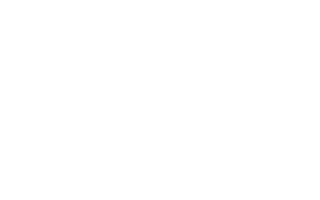

In [15]:
screen.show(True)